In [99]:
import pandas as pd
import re
import numpy as np
from scipy import stats
import scipy as sp
from sklearn import metrics

import os
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.precision', 4)

In [2]:
def score_col_splitter(X, score_col):

    quarter = score_col.split("_")[0]
    
    X['Home_Score'] = X[score_col].apply(lambda x: x.split(" - ")[0].split(".")[-1]).astype(int)
    X['Home_Goals'] = X[score_col].apply(lambda x: x.split(" - ")[0].split(".")[0]).astype(int)
    X['Home_Behinds'] = X[score_col].apply(lambda x: x.split(" - ")[0].split(".")[1]).astype(int)
    X['Home_Shots'] = X['Home_Goals'] + X['Home_Behinds']
    X['Home_Conversion'] = X['Home_Goals'] / X['Home_Shots']
    
    X['Away_Score'] = X[score_col].apply(lambda x: x.split(" - ")[1].split(".")[-1]).astype(int)
    X['Away_Goals'] = X[score_col].apply(lambda x: x.split(" - ")[1].split(".")[0]).astype(int)
    X['Away_Behinds'] = X[score_col].apply(lambda x: x.split(" - ")[1].split(".")[1]).astype(int)
    X['Away_Shots'] = X['Away_Goals'] + X['Away_Behinds']
    X['Away_Conversion'] = X['Away_Goals'] / X['Away_Shots']
        
    return X

Load Match Summary Data

In [3]:
match_summary = pd.read_csv("/Users/ciaran/Documents/Projects/AFL/data/match_summary.csv")
match_summary = score_col_splitter(match_summary, "Q4_Score")
match_summary['Season'] = match_summary['Match_ID'].apply(lambda x: int(x[:4]))
match_summary.head()

,Home_Team,Away_Team,Q4_Score,Margin,Total Game Score,Home Win,Venue,City,Date,Attendance,Temperature,Weather_Type,Year,Round_ID,Match_ID,Season,Home_Score,Home_Goals,Home_Behinds,Home_Shots,Home_Conversion,Away_Score,Away_Goals,Away_Behinds,Away_Shots,Away_Conversion
0,Brisbane Lions,Sydney,14.10.94 - 19.11.125,-31,219,0.0,Gabba,Brisbane,2021-03-20 19:45:00,0,18,MOSTLY_SUNNY,2021,202101,202101_BrisbaneLions_Sydney,2021,94,14,10,24,0.5833,125,19,11,30,0.6333
1,Collingwood,Western Bulldogs,7.11.53 - 10.9.69,-16,122,0.0,M.C.G.,Melbourne,2021-03-19 19:50:00,0,27,MOSTLY_SUNNY,2021,202101,202101_Collingwood_WesternBulldogs,2021,53,7,11,18,0.3889,69,10,9,19,0.5263
2,Essendon,Hawthorn,13.13.91 - 14.8.92,-1,183,0.0,Docklands,Melbourne,2021-03-20 19:25:00,0,26,MOSTLY_SUNNY,2021,202101,202101_Essendon_Hawthorn,2021,91,13,13,26,0.5000,92,14,8,22,0.6364
3,Greater Western Sydney,St Kilda,11.12.78 - 13.8.86,-8,164,0.0,Sydney Showground,Sydney,2021-03-21 15:20:00,0,22,RAIN,2021,202101,202101_GreaterWesternSydney_StKilda,2021,78,11,12,23,0.4783,86,13,8,21,0.6190
4,Melbourne,Fremantle,11.14.80 - 8.10.58,22,138,1.0,M.C.G.,Melbourne,2021-03-20 13:45:00,0,26,MOSTLY_SUNNY,2021,202101,202101_Melbourne_Fremantle,2021,80,11,14,25,0.4400,58,8,10,18,0.4444


Load Player Stats Data

In [5]:
player_stats = pd.read_csv("/Users/ciaran/Documents/Projects/AFL/data/scored_player_stats.csv")
player_stats['Season'] = player_stats['Match_ID'].apply(lambda x: int(x[:4]))
player_stats['Player_Season'] = player_stats['Player'] + "_" + player_stats['Season'].astype(str)

player_stats['Score'] = player_stats['Behinds'] + player_stats['Goals']*6
player_stats['xScore_Diff'] = player_stats['Score'] - player_stats['xScore']

player_stats['Home_Team'] = player_stats['Match_ID'].apply(lambda x: x.split("_")[1]).str.replace(r"([A-Z])", r" \1").str.strip()
player_stats['Away_Team'] = player_stats['Match_ID'].apply(lambda x: x.split("_")[-1]).str.replace(r"([A-Z])", r" \1").str.strip()
player_stats['Opponent'] = np.where(player_stats['Team'] == player_stats['Home_Team'], player_stats['Away_Team'], player_stats['Home_Team'])

finals_round_map = {'F1':24,
                    'F2':25,
                    'F3':26,
                    'F4':27}
player_stats['Round_ID'] = player_stats['Round_ID'].astype(str)
player_stats['Round'] = (player_stats['Round_ID'].str[4:].replace(finals_round_map)).astype(int)
player_stats['Round_str'] = player_stats['Round_ID'].str[4:].replace(finals_round_map)
player_stats['Round_ID_num'] = (player_stats['Season'].astype(str) + player_stats['Round'].astype(str)).astype(int)

player_stats.tail()

,Match_ID,Team,Player,Round_ID,AFL_API_Player_ID,Player_Type,playerId,Age,Height,Weight,Number,Kicking_Foot,State_Of_Origin,Draft_Year,Debut_Year,Recruited_From,Draft_Position,Draft_Type,Photo_URL,Date_Of_Birth,Percent_Played,Behinds,Bounces,Centre_Bounces_Attended,Centre_Clearances,Clangers,Defensive_Contest_Losses,Defensive_Contest_Loss_Percentage,Defensive_One_On_One_Contests,Contested_Marks,Contested_Possession_Rate,Contested_Possessions,Offensive_One_On_One_Contests,Offensive_Contest_Wins,Offensive_Contest_Win_Percentage,Defensive_Half_Pressure_Acts,Disposal_Efficiency,Disposals,AFL_Fantasy_Points,Effective_Disposals,Effective_Kicks,Inside_50_Ground_Ball_Gets,Frees_Against,Frees_For,Goal_Accuracy,Goal_Assists,Goals,Ground_Ball_Gets,Handballs,Hit_Outs,Hit_Outs_To_Advantage,Hit_Outs_To_Advantage_Rate,Hit_Out_Win_Percentage,Inside_50s,Intercept_Marks,Intercepts,Kick_Efficiency,Kick_Ins,Kick_Ins_Played_On,Kicks,Kick_To_Handball_Ratio,Marks,Marks_Inside_50,Marks_On_Lead,Metres_Gained,One_Percenters,Pressure_Acts,Player_Rating_Points,Rebound_50s,Ruck_Contests,Score_Involvements,Score_Launches,Shots_At_Goal,Spoils,Stoppage_Clearances,Tackles,Tackles_Inside_50,Clearances,Possessions,Turnovers,Uncontested_Possessions,AFLCA_Player_ID,Coaches_Votes,Position,Team_Status,Position_Sub_Group,Position_Group,Year,Brownlow_Votes,Season,xScore,xT_created,xT_denied,vaep_value,offensive_value,defensive_value,exp_vaep_value,exp_offensive_value,exp_defensive_value,xT_received,xT_prevented,vaep_value_received,exp_vaep_value_received,Player_Season,Score,xScore_Diff,Home_Team,Away_Team,Opponent,Round,Round_str,Round_ID_num
27846,202323_WesternBulldogs_WestCoast,Western Bulldogs,Oskar Baker,202323,Oskar_Baker,MIDFIELDER,CD_I1008855,25,184,87,13,RIGHT,QLD,2017.0,2019.0,Wilston Grange (Qld)/Aspley (NEAFL)/Melbourne,48.0,nationalDraft,https://s.afl.com.au/staticfile/AFL Tenant/AFL...,1998-05-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Half Forward Flank Right,FINAL_TEAM,Half-Forward,Forward,NaN,NaN,2023,7.9598,-0.3226,0.0167,0.3991,0.7006,-0.3015,2.8523,3.8194,-0.9671,-0.3267,0.0713,1.0483,3.4625,Oskar Baker_2023,NaN,NaN,Western Bulldogs,West Coast,West Coast,23,23,202323
27847,202323_WesternBulldogs_WestCoast,Western Bulldogs,Rhylee West,202323,Rhylee_West,MEDIUM_FORWARD,CD_I1006127,23,183,82,14,RIGHT,VIC,2018.0,2019.0,Strathmore (Vic)/St Kevin&apos;s College (Vic)...,26.0,fatherSon,https://s.afl.com.au/staticfile/AFL Tenant/AFL...,2000-07-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Forward Pocket Right,FINAL_TEAM,Forward-Pocket,Forward,NaN,NaN,2023,9.7706,0.1389,0.0000,0.5694,0.6452,-0.0758,7.0749,7.4761,-0.4012,0.4868,0.0043,0.9269,6.2204,Rhylee West_2023,NaN,NaN,Western Bulldogs,West Coast,West Coast,23,23,202323
27848,202323_WesternBulldogs_WestCoast,Western Bulldogs,Rory Lobb,202323,Rory_Lobb,KEY_FORWARD,CD_I990740,30,207,106,7,RIGHT,WA,2013.0,2014.0,Bassendean (WA)/Swan Districts (WAFL)/GWS/Frem...,29.0,nationalDraft,https://s.afl.com.au/staticfile/AFL Tenant/AFL...,1993-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Forward Pocket Left,FINAL_TEAM,Forward-Pocket,Forward,NaN,NaN,2023,17.1166,-0.1439,-0.0025,1.7295,1.8518,-0.1224,11.1693,12.7523,-1.5830,0.4878,-0.0002,1.1501,10.5511,Rory Lobb_2023,NaN,NaN,Western Bulldogs,West Coast,West Coast,23,23,202323
27849,202323_WesternBulldogs_WestCoast,Western Bulldogs,Taylor Duryea,

Create Match Level Expected Data from Player Stats

In [6]:
match_stats = player_stats.groupby(['Match_ID', 'Team', 'Home_Team']).sum()[['Score', 'xScore', 'vaep_value', 'offensive_value', 'defensive_value', 'exp_vaep_value', 'exp_offensive_value', 'exp_defensive_value']].reset_index()
match_stats['Home_Away'] = np.where(match_stats['Team'] == match_stats['Home_Team'], 'Home', 'Away')
match_stats = match_stats.pivot(index = 'Match_ID', columns = 'Home_Away', values = ['xScore', 'vaep_value', 'offensive_value', 'defensive_value', 'exp_vaep_value', 'exp_offensive_value', 'exp_defensive_value'])
match_stats.columns = ['_'.join((y, x)) for (x, y) in match_stats.columns]
match_stats.head()

,Away_xScore,Home_xScore,Away_vaep_value,Home_vaep_value,Away_offensive_value,Home_offensive_value,Away_defensive_value,Home_defensive_value,Away_exp_vaep_value,Home_exp_vaep_value,Away_exp_offensive_value,Home_exp_offensive_value,Away_exp_defensive_value,Home_exp_defensive_value
Match_ID,,,,,,,,,,,,,,
202101_BrisbaneLions_Sydney,92.4685,69.7281,24.2606,19.2363,22.3104,16.3960,1.9501,2.8403,121.0789,100.5702,114.2657,87.4443,6.8132,13.1260
202101_Collingwood_WesternBulldogs,89.9581,60.3994,15.9335,13.9565,13.1114,10.0669,2.8221,3.8897,126.5315,99.6866,112.0616,84.0031,14.4699,15.6836
202101_Essendon_Hawthorn,90.4045,93.4030,21.0892,20.2102,18.6803,15.8776,2.4089,4.3326,117.6707,118.2525,109.9257,105.5508,7.7450,12.7016
202101_GreaterWesternSydney_StKilda,80.1441,92.1888,20.6573,18.4181,16.8530,15.0227,3.8042,3.3954,111.5834,127.2029,104.5752,109.8564,7.0082,17.3465
202101_Melbourne_Fremantle,68.4989,98.1589,12.3997,14.5982,10.7470,11.9639,1.6527,2.6343,85.5965,115.5518,83.4532,106.5428,2.1433,9.0090


Merge Match Summary and Stats Data

In [7]:
match_summary_stats = match_summary.merge(match_stats, how = "left", on = "Match_ID")

In [8]:
match_summary_stats.head()

,Home_Team,Away_Team,Q4_Score,Margin,Total Game Score,Home Win,Venue,City,Date,Attendance,Temperature,Weather_Type,Year,Round_ID,Match_ID,Season,Home_Score,Home_Goals,Home_Behinds,Home_Shots,Home_Conversion,Away_Score,Away_Goals,Away_Behinds,Away_Shots,Away_Conversion,Away_xScore,Home_xScore,Away_vaep_value,Home_vaep_value,Away_offensive_value,Home_offensive_value,Away_defensive_value,Home_defensive_value,Away_exp_vaep_value,Home_exp_vaep_value,Away_exp_offensive_value,Home_exp_offensive_value,Away_exp_defensive_value,Home_exp_defensive_value
0,Brisbane Lions,Sydney,14.10.94 - 19.11.125,-31,219,0.0,Gabba,Brisbane,2021-03-20 19:45:00,0,18,MOSTLY_SUNNY,2021,202101,202101_BrisbaneLions_Sydney,2021,94,14,10,24,0.5833,125,19,11,30,0.6333,92.4685,69.7281,24.2606,19.2363,22.3104,16.3960,1.9501,2.8403,121.0789,100.5702,114.2657,87.4443,6.8132,13.1260
1,Collingwood,Western Bulldogs,7.11.53 - 10.9.69,-16,122,0.0,M.C.G.,Melbourne,2021-03-19 19:50:00,0,27,MOSTLY_SUNNY,2021,202101,202101_Collingwood_WesternBulldogs,2021,53,7,11,18,0.3889,69,10,9,19,0.5263,89.9581,60.3994,15.9335,13.9565,13.1114,10.0669,2.8221,3.8897,126.5315,99.6866,112.0616,84.0031,14.4699,15.6836
2,Essendon,Hawthorn,13.13.91 - 14.8.92,-1,183,0.0,Docklands,Melbourne,2021-03-20 19:25:00,0,26,MOSTLY_SUNNY,2021,202101,202101_Essendon_Hawthorn,2021,91,13,13,26,0.5000,92,14,8,22,0.6364,90.4045,93.4030,21.0892,20.2102,18.6803,15.8776,2.4089,4.3326,117.6707,118.2525,109.9257,105.5508,7.7450,12.7016
3,Greater Western Sydney,St Kilda,11.12.78 - 13.8.86,-8,164,0.0,Sydney Showground,Sydney,2021-03-21 15:20:00,0,22,RAIN,2021,202101,202101_GreaterWesternSydney_StKilda,2021,78,11,12,23,0.4783,86,13,8,21,0.6190,80.1441,92.1888,20.6573,18.4181,16.8530,15.0227,3.8042,3.3954,111.5834,127.2029,104.5752,109.8564,7.0082,17.3465
4,Melbourne,Fremantle,11.14.80 - 8.10.58,22,138,1.0,M.C.G.,Melbourne,2021-03-20 13:45:00,0,26,MOSTLY_SUNNY,2021,202101,202101_Melbourne_Fremantle,2021,80,11,14,25,0.4400,58,8,10,18,0.4444,68.4989,98.1589,12.3997,14.5982,10.7470,11.9639,1.6527,2.6343,85.5965,115.5518,83.4532,106.5428,2.1433,9.0090


Home Advantage

In [9]:
match_summary_stats['Home Win'].mean()

0.5683690280065898

In [10]:
match_summary_stats.groupby('Season').mean()['Home Win']

Season
2021    0.5218
2022    0.6014
2023    0.5825
Name: Home Win, dtype: float64

In [11]:
match_summary_stats.groupby('Home Win').mean()['Margin'].sum()

4.311273679694736

In [12]:
match_summary_stats.groupby(['Season', 'Home Win']).mean()['Margin'].groupby('Season').sum()

Season
2021     6.4198
2022    -3.6583
2023    10.4268
Name: Margin, dtype: float64

In [13]:
starting_home_advantage = match_summary_stats[match_summary_stats['Season']==2021]['Home Win'].mean() / 0.5
starting_home_advantage

1.0436893203883495

Team Ratings

Team Ratings are going to be normally distributed, around some mean value with a standard deviation (average rating and confidence/variance in that rating/future performance.)

Team ratings should not account for Home advantage, but should get updated compared to their pre-match expectations. (Bayesian update)

Team performances will be the team rating + some home advantage modifier + consideration of opposition team rating and will be normally distributed.

Team Ratings are based on Expected Scores and Expected VAEP Values for each match by a team, the HA-neutralised ones.

Team Ratings highly depend on the individual Player Ratings that are playing for that team in that match.
Ideally Team Ratings are the sum of individual Player Ratings.

Player Ratings are normally distributed, around some mean value with a standard deviation (average rating and variance in performance).

Player ratings should not account for Home advantage, but should get updated compared to their pre-match expectations. (Bayesian update)

Player performances will be the Player rating + some home advantage modifier + consideration of opposition team rating and will be normally distributed.

Player Ratings are based on Expected Vaep Values for each match by a player. These will be scaled/proportioned into the HA-neutralised Expected Score of the team.



- Individual player ratings based on past Expected VAEP values
- Team ratings are the combined player ratings for whoever is playing
- Home advantage is some multiplier/adjustment that is applied to home/away team
- Predicted match outcome, probability, margin is based on both team's ratings
- Match happens
- Actual match outcome, margin is available
- Expected VAEP values for each player is available for latest game
- Player ratings are updated based on their Expected VAEP in the match compared to their prior Expected VAEP (HA-neutral)
- Team ratings are (either) updated based on new player ratings (or) updated based on actual margin compared to predicted margin (HA-neutral)

Player Values

In [14]:
starting_player_values = player_stats[player_stats['Season'] == 2021].groupby(['Player', 'Team']).mean()[['exp_vaep_value', 'exp_offensive_value', 'exp_defensive_value']].reset_index()
starting_player_values.sort_values(by = 'exp_vaep_value',ascending = False).head(10)

,Player,Team,exp_vaep_value,exp_offensive_value,exp_defensive_value
599,Toby Greene,Greater Western Sydney,12.1438,12.8986,-0.7548
154,Dayne Zorko,Brisbane Lions,10.6815,10.2189,0.4626
568,Shai Bolton,Richmond,10.4440,10.7751,-0.3311
112,Clayton Oliver,Melbourne,10.4249,9.9593,0.4657
42,Ben Cunnington,North Melbourne,10.2914,9.5541,0.7373
110,Christian Petracca,Melbourne,10.2715,10.8995,-0.6280
268,Jake Stringer,Essendon,10.2214,10.8140,-0.5926
245,Jack Steele,St Kilda,9.8891,9.2413,0.6478
232,Jack Macrae,Western Bulldogs,9.8434,9.1868,0.6566
178,Elliot Yeo,West Coast,9.8165,8.9443,0.8722


In [66]:
starting_player_stds = player_stats[player_stats['Season'] == 2021].groupby('Player').std()[['exp_offensive_value', 'exp_defensive_value']].reset_index()
starting_player_stds.columns = ['Player', 'exp_offensive_value_std', 'exp_defensive_value_std']
starting_player_stds.sort_values(by = 'exp_offensive_value_std', ascending = False).head(10)

,Player,exp_offensive_value_std,exp_defensive_value_std
2,Aaron Naughton,6.7558,0.8957
72,Brendon Ah Chee,6.4003,1.1516
177,Eddie Ford,6.0882,0.3139
590,Taylor Walker,5.9785,1.1573
617,Tom J. Lynch,5.9632,1.0408
494,Orazio Fantasia,5.8227,0.7301
504,Patrick Dangerfield,5.8206,1.2537
45,Ben King,5.8037,0.6249
305,Jeremy Cameron,5.5116,0.6970
113,Cody Weightman,5.5093,0.6889


Match Level Player Ratings & Team Ratings

In [15]:
match_player_stats = player_stats[player_stats['Match_ID'] == "202201_Melbourne_WesternBulldogs"]
home_players = list(match_player_stats[match_player_stats['Team'] == match_player_stats['Home_Team']]['Player'].unique())
away_players = list(match_player_stats[match_player_stats['Team'] != match_player_stats['Home_Team']]['Player'].unique())
home_rating = starting_player_values[starting_player_values['Player'].isin(home_players)]['exp_vaep_value'].sum()
away_rating = starting_player_values[starting_player_values['Player'].isin(away_players)]['exp_vaep_value'].sum()
home_offensive_rating = starting_player_values[starting_player_values['Player'].isin(home_players)]['exp_offensive_value'].sum()
home_defensive_rating = starting_player_values[starting_player_values['Player'].isin(home_players)]['exp_defensive_value'].sum()
away_offensive_rating = starting_player_values[starting_player_values['Player'].isin(away_players)]['exp_offensive_value'].sum()
away_defensive_rating = starting_player_values[starting_player_values['Player'].isin(away_players)]['exp_defensive_value'].sum()

Home Advantage Adjusted Home Team Ratings

In [16]:
home_rating_ha = home_rating * starting_home_advantage
home_offensive_rating_ha = home_offensive_rating * starting_home_advantage
home_defensive_rating_ha = home_defensive_rating * starting_home_advantage

In [17]:
home_rating, home_rating_ha, away_rating

(120.65547921207504, 125.92683509998122, 127.9830847182428)

In [18]:
home_offensive_rating, home_offensive_rating_ha, away_offensive_rating

(110.98500927333592, 115.83386890178264, 114.55473838595543)

In [19]:
home_defensive_rating, home_defensive_rating_ha, away_defensive_rating

(9.670469945826618, 10.092966205595742, 13.42834638390561)

In [20]:
home_match_rating = home_offensive_rating_ha - away_defensive_rating
away_match_rating = away_offensive_rating - home_defensive_rating_ha
home_match_rating, away_match_rating

(102.40552251787703, 104.46177218035969)

Team Standard Deviation Estimate

In [21]:
match_summary_stats[['Home_exp_vaep_value', 'Away_exp_vaep_value']].std()

Home_exp_vaep_value    21.9364
Away_exp_vaep_value    20.8923
dtype: float64

In [22]:
starting_std_value = 20

Turn Team Ratings into Match Predictions

In [31]:
def calculate_probabilities(home_mean, home_std, away_mean, away_std):
    
    mean = home_mean - away_mean
    std = home_std + away_std
    diff = stats.norm(loc = mean, scale = std)
    
    away_prob = diff.cdf(0)
    draw_prob = diff.pdf(0)
    home_prob = 1 - away_prob - draw_prob
    
    return home_prob, draw_prob, away_prob

In [32]:
home_predicted_prob, draw_predicted_prob, away_predicted_prob = calculate_probabilities(home_match_rating, starting_std_value, away_match_rating, starting_std_value)
home_predicted_prob, draw_predicted_prob, away_predicted_prob

(0.46954051800881047, 0.009960387643086611, 0.5204990943481029)

Get Actual Match Result

In [39]:
match_player_stats.head()

,Match_ID,Team,Player,Round_ID,AFL_API_Player_ID,Player_Type,playerId,Age,Height,Weight,Number,Kicking_Foot,State_Of_Origin,Draft_Year,Debut_Year,Recruited_From,Draft_Position,Draft_Type,Photo_URL,Date_Of_Birth,Percent_Played,Behinds,Bounces,Centre_Bounces_Attended,Centre_Clearances,Clangers,Defensive_Contest_Losses,Defensive_Contest_Loss_Percentage,Defensive_One_On_One_Contests,Contested_Marks,Contested_Possession_Rate,Contested_Possessions,Offensive_One_On_One_Contests,Offensive_Contest_Wins,Offensive_Contest_Win_Percentage,Defensive_Half_Pressure_Acts,Disposal_Efficiency,Disposals,AFL_Fantasy_Points,Effective_Disposals,Effective_Kicks,Inside_50_Ground_Ball_Gets,Frees_Against,Frees_For,Goal_Accuracy,Goal_Assists,Goals,Ground_Ball_Gets,Handballs,Hit_Outs,Hit_Outs_To_Advantage,Hit_Outs_To_Advantage_Rate,Hit_Out_Win_Percentage,Inside_50s,Intercept_Marks,Intercepts,Kick_Efficiency,Kick_Ins,Kick_Ins_Played_On,Kicks,Kick_To_Handball_Ratio,Marks,Marks_Inside_50,Marks_On_Lead,Metres_Gained,One_Percenters,Pressure_Acts,Player_Rating_Points,Rebound_50s,Ruck_Contests,Score_Involvements,Score_Launches,Shots_At_Goal,Spoils,Stoppage_Clearances,Tackles,Tackles_Inside_50,Clearances,Possessions,Turnovers,Uncontested_Possessions,AFLCA_Player_ID,Coaches_Votes,Position,Team_Status,Position_Sub_Group,Position_Group,Year,Brownlow_Votes,Season,xScore,xT_created,xT_denied,vaep_value,offensive_value,defensive_value,exp_vaep_value,exp_offensive_value,exp_defensive_value,xT_received,xT_prevented,vaep_value_received,exp_vaep_value_received,Player_Season,Score,xScore_Diff,Home_Team,Away_Team,Opponent,Round,Round_str,Round_ID_num
9759,202201_Melbourne_WesternBulldogs,Melbourne,Adam Tomlinson,202201,Adam_Tomlinson,KEY_DEFENDER,CD_I291819,28,194,95,20,RIGHT,VIC,2011.0,2012.0,Canterbury (Vic)/Trinity Grammar (Vic)/Oakleig...,9.0,nationalDraft,https://s.afl.com.au/staticfile/AFL Tenant/AFL...,1993-08-10,100.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,33.3,3.0,0.0,0.0,0.0,3.0,75.0,8.0,35.0,6.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,66.7,0.0,0.0,6.0,3.0,4.0,0.0,0.0,151.0,4.0,4.0,2.9,1.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,9.0,3.0,6.0,NaN,NaN,Centre Half Back,FINAL_TEAM,Key-Back,Back,NaN,NaN,2022,0.0000,-0.3239,0.0341,-0.1268,-0.0088,-0.1180,1.7637,0.8481,0.9156,-0.2138,0.1927,-0.3206,-0.1645,Adam Tomlinson_2022,0.0,0.0000,Melbourne,Western Bulldogs,Western Bulldogs,1,01,20221
9760,202201_Melbourne_WesternBulldogs,Melbourne,Alex Neal-Bullen,202201,Alex_Neal-Bullen,MEDIUM_FORWARD,CD_I296420,26,183,81,30,RIGHT,SA,2014.0,2015.0,Plympton (SA)/Glenelg (SANFL),40.0,nationalDraft,https://s.afl.com.au/staticfile/AFL Tenant/AFL...,1996-01-09,88.0,1.0,2.0,5.0,0.0,1.0,0.0,0.0,0.0,1.0,44.4,8.0,0.0,0.0,0.0,12.0,72.2,18.0,85.0,13.0,6.0,1.0,0.0,1.0,0.0,3.0,0.0,6.0,8.0,0.0,0.0,0.0,0.0,6.0,1.0,4.0,60.0,0.0,0.0,10.0,1.3,3.0,0.0,0.0,320.0,2.0,29.0,12.1,0.0,0.0,8.0,3.0,1.0,1.0,0.0,7.0,1.0,0.0,18.0,4.0,10.0,NaN,NaN,Half Forward Flank Right,FINAL_TEAM,Half-Forward,Forward,NaN,NaN,2022,3.4007,0.0735,0.0579,0.6447,0.6378,0.0069,6.2626,5.6120,0.6506,0.3239,0.0689,1.1375,6.8563,Alex Neal-Bullen_2022,1.0,-2.4007,Melbourne,Western Bulldogs,Western Bulldogs,1,01,20221
9761,202201_Melbourne_WesternBulldogs,Melbourne,Angus Brayshaw,202201,Angus_Brayshaw,MEDIUM_DEFENDER,CD_I298279,26,187,92,10,RIGHT,VIC,2014.0,2015.0,Hampton Rovers (Vic)/Sandringham U18,3.0,nationalDraft,https://s.afl.com.au/staticfile/AFL Tenant/AFL...,1996-01-09,83.0,0.0,0.0,0.0,0.0,4.0,1.0,100.0,1.0,0.0,17.4,4.0,0.0,0.0,0.0,3.0,65.2,23.0,86.0,15.0,9.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,11.0,0.0,0.0,0.0,0.0,2.0,3.0,7.0,75.0,0.0,0.0,12.0,1.1,6.0,0.0,0.0,272.0,1.0,7.0,3.3,2.0,0.0,3.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,23.0,3.0,19.0,NaN,NaN,Half Back Flank Right,FINAL_TEAM,Half-Back,Back,NaN,NaN,2022,0.0000,-0.2260,0.0612,0.1956,0.2423,-0.0467,1.6399,2.3615,-0.7215,-0.2951,0.2156,0.0937,-0.7763,Angus Brayshaw_2022,0.0,0.0000,Melbourne,Western Bulldogs,Western Bulldogs,1,01,20221
9762,202201_Melbourne_WesternBulldogs,Melbo

In [49]:
home_actual_offensive_rating_ha = match_player_stats[match_player_stats['Team'] == match_player_stats['Home_Team']]['exp_offensive_value'].sum()
home_actual_defensive_rating_ha = match_player_stats[match_player_stats['Team'] == match_player_stats['Home_Team']]['exp_defensive_value'].sum()

home_actual_offensive_rating = home_actual_offensive_rating_ha / starting_home_advantage
home_actual_defensive_rating = home_actual_defensive_rating_ha / starting_home_advantage

away_actual_offensive_rating = match_player_stats[match_player_stats['Team'] != match_player_stats['Home_Team']]['exp_offensive_value'].sum()
away_actual_defensive_rating = match_player_stats[match_player_stats['Team'] != match_player_stats['Home_Team']]['exp_defensive_value'].sum()

home_actual_offensive_rating_ha, home_actual_offensive_rating, home_actual_defensive_rating_ha, home_actual_defensive_rating, away_actual_offensive_rating, away_actual_defensive_rating

(122.60482858083999,
 117.47253343094437,
 16.601954696773,
 15.906989151326687,
 82.1030578907,
 11.745696560322028)

In [48]:
home_actual_rating = home_actual_offensive_rating_ha - away_actual_defensive_rating
away_actual_rating = away_actual_offensive_rating - home_actual_defensive_rating_ha
home_actual_rating, away_actual_rating

(110.85913202051796, 65.50110319392701)

Checking if Player Value Aggregation is the same

In [75]:
home_actual_player_values = match_player_stats[match_player_stats['Team'] == match_player_stats['Home_Team']][['Player', 'Team', 'exp_vaep_value', 'exp_offensive_value', 'exp_defensive_value']]
home_actual_player_values = home_actual_player_values.rename(columns = {
    'exp_vaep_value':'actual_exp_vaep_value_ha',
    'exp_offensive_value':'actual_exp_offensive_value_ha',
    'exp_defensive_value':'actual_exp_defensive_value_ha'})
away_actual_player_values = match_player_stats[match_player_stats['Team'] != match_player_stats['Home_Team']][['Player', 'Team', 'exp_vaep_value', 'exp_offensive_value', 'exp_defensive_value']]
away_actual_player_values = away_actual_player_values.rename(columns = {
    'exp_vaep_value':'actual_exp_vaep_value',
    'exp_offensive_value':'actual_exp_offensive_value',
    'exp_defensive_value':'actual_exp_defensive_value'})

In [74]:
assert home_actual_player_values['actual_exp_offensive_value_ha'].sum() == home_actual_offensive_rating_ha

In [76]:
home_actual_player_values['actual_exp_offensive_value'] = home_actual_player_values['actual_exp_offensive_value_ha'] / starting_home_advantage

In [80]:
assert round(home_actual_player_values['actual_exp_offensive_value'].sum(), 5), round(home_actual_offensive_rating, 5)

Bayesian Value Updating

In [69]:
home_prior_player_values = starting_player_values[starting_player_values['Player'].isin(home_players)]
home_prior_player_stds = starting_player_stds[starting_player_stds['Player'].isin(home_players)]
home_prior_player_values = home_prior_player_values.merge(home_prior_player_stds, how = 'left', on = ['Player'])
away_prior_player_values = starting_player_values[starting_player_values['Player'].isin(away_players)]
away_prior_player_stds = starting_player_stds[starting_player_stds['Player'].isin(away_players)]
away_prior_player_values = away_prior_player_values.merge(away_prior_player_stds, how = 'left', on = ['Player'])

In [72]:
home_player_values = home_prior_player_values.merge(home_actual_player_values, how = 'left', on = ['Player', 'Team'])
home_player_values[['Player', 'exp_offensive_value', 'exp_offensive_value_std', 'actual_exp_offensive_value']]

,Player,exp_offensive_value,exp_offensive_value_std,actual_exp_offensive_value
0,Adam Tomlinson,0.8936,1.7327,0.8481
1,Alex Neal-Bullen,3.9892,2.9122,5.6120
2,Angus Brayshaw,4.2726,3.0944,2.3615
3,Bayley Fritsch,7.3858,3.7099,12.3270
4,Ben Brown,7.2357,3.4335,6.1275
5,Charlie Spargo,4.5879,3.3124,8.1413
6,Christian Petracca,10.8995,4.8021,16.7451
7,Christian Salem,4.9484,3.0850,0.4968
8,Clayton Oliver,9.9593,4.8195,10.7714
9,Ed Langdon,4.7460,2.9428,8.1605


posterior = (likelihood * prior) / evidence

- prior - probability distribution based on our current view of mean and variance
- likelihood - probability density of getting the new value
- evidence - probability that the new value is produced

In [91]:
import matplotlib.pyplot as plt

(10.899465060152, 4.802073529629512)


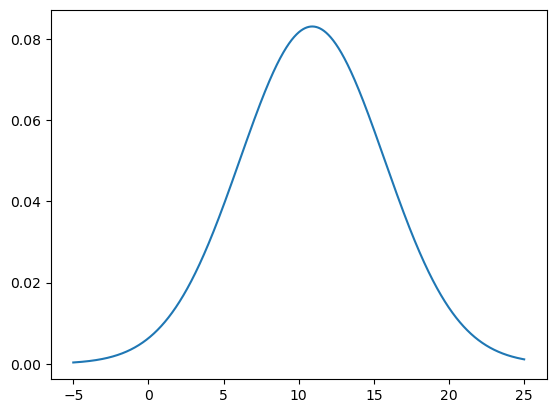

In [193]:
player = "Christian Petracca"
mu = np.linspace(-5, 25, num=10000)

# prior
prior_mean = home_player_values[home_player_values['Player'] == player]['exp_offensive_value'].iloc[0]
prior_std = home_player_values[home_player_values['Player'] == player]['exp_offensive_value_std'].iloc[0]
prior_dist = stats.norm.pdf(mu, loc = prior_mean, scale = prior_std)
# prior_dist = prior_dist/prior_dist.sum()
print((prior_mean, prior_std))
plt.plot(mu, prior_dist)


In [197]:
compute_percentile(mu, prior_dist, percentile=0.5)

10.904590459045904

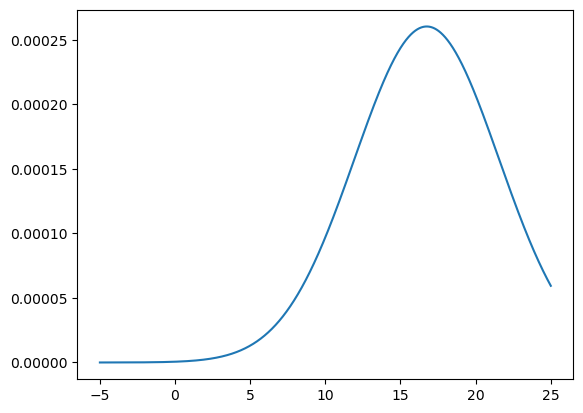

In [161]:
# likelihood
new_data = home_player_values[home_player_values['Player'] == player]['actual_exp_offensive_value'].iloc[0]
def likelihood_func(data, mu, sigma):
    likelihood_out = stats.norm.pdf(data, mu, scale=sigma)
    return likelihood_out / likelihood_out.sum()

likelihood_out = likelihood_func(new_data, mu, prior_std)

plt.plot(mu, likelihood_out)

0.00012706111888684292 1.0


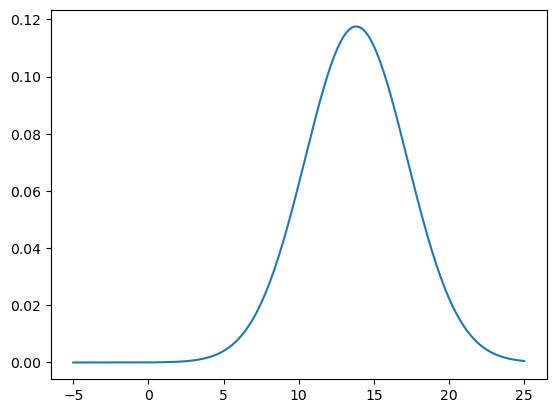

In [201]:
# evidence
unnormalized_posterior = likelihood_out * prior_dist
p_data = sp.integrate.trapz(unnormalized_posterior, mu)
normalized_posterior = unnormalized_posterior / p_data
print(sp.integrate.trapz(unnormalized_posterior, mu), sp.integrate.trapz(normalized_posterior, mu))
plt.plot(mu, normalized_posterior)

In [205]:
posterior_mean = (((1/prior_std)*prior_mean) + ((1/prior_std)*new_data)) / ((1/prior_std) + (1/prior_std))
posterior_std = (prior_std*prior_std)/(prior_std+prior_std)

In [163]:
def compute_percentile(parameter_values, distribution_values, percentile=0.5):
    cumulative_distribution = sp.integrate.cumtrapz(
        distribution_values, parameter_values)
    percentile_index = np.searchsorted(cumulative_distribution, percentile)
    return parameter_values[percentile_index]

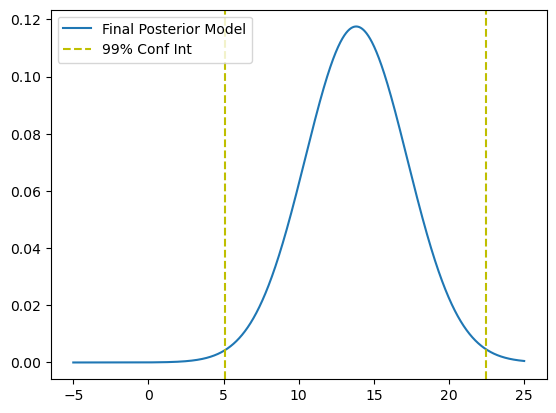

In [165]:
plt.plot(mu, normalized_posterior, label = 'Final Posterior Model')
plt.axvline(x = compute_percentile(mu, normalized_posterior, 0.005), ls = '--', color = 'y', label = '99% Conf Int')
plt.axvline(x = compute_percentile(mu, normalized_posterior, 0.995), ls = '--', color = 'y')
plt.legend()